# Machine Learning Classification with a cervical cancer dataset 



Student: Giovanni Rosati (part-time pacing)
    
Pacing: part-time

Scheduled project review date/time: TBD

Instructor: Jeff Herman

Blog URL: TBD

GitHub Repository: https://github.com/giorosati/dsc-3-final-project-online-ds-pt-100118

### Citation requested by dataset publisher:

Kelwin Fernandes, Jaime S. Cardoso, and Jessica Fernandes. 'Transfer Learning with Partial Observability Applied to Cervical Cancer Screening.' Iberian Conference on Pattern Recognition and Image Analysis. Springer International Publishing, 2017.

Dataset link: https://archive.ics.uci.edu/ml/datasets/Cervical+cancer+%28Risk+Factors%29#

### Project Overview

The objective of this project is to develop a machine learning model(s) that can accurately predict the presence of cervical cancer (as determined by a bioppsy) from as many as 35 possible risk factors recorded for each woman in the datset. A challenge when developing prediction models for this type of data is the balance between precision and recall:
* Precision will represent the proportion of the models' predictions of cancer where cancer is actually present.
* Recall will represent the proportion of the actual cases of cancer that the model accurately predicted. 

Because not "capturing" even one case of cancer could result in death, the models should place appropriate emphasis on the recall score - it is preferrable to not miss anyone that has a signifigant probability of cancer even if that means "flagging" some patients as likely to have cancer that are actually cancer free.  

Another challenge with this type of data is that positive cases (cancer present) are typically (thankfully!) a small proportion of the total patients. This unbalanced nature of the data can make prediction more difficult for machine learning models, especially KNN (K nearest neighbors), simply because there are fewer cases to learn from. For example, imagine a dataset with 1,000 records where 20 are actually positive for the presence of a particular cancer (very possible):
* A model that predicts that everyone has cancer would have a precision score of 4% but a recall score of 100%. All these patients would likely be subjected to a biopsy, capturing all the cancer cases but subjecting 960 women to an unneccesary proceedure.

The goal is to identify a very high percentage of cancer cases with as few as possible "false positives".

The dataset was collected at 'Hospital Universitario de Caracas' in Caracas, Venezuela. The dataset comprises 35 factors that include demographic information, habits, and historic medical records of 858 patients. Several patients decided not to answer some of the questions because of privacy concerns (missing values). The dataset comes from a research paper first published online in May, 2017.

My approach will follow the OSEMN protocol:
* Obtain
* Scrub
* Explore
* Model
* iNterpret

## Obtain
The dataset will be obtained from the University of California at Irvine (UCI) Machine Learning Repository:
https://archive.ics.uci.edu/ml/datasets/Cervical+cancer+%28Risk+Factors%29#

## Scrub
After an initial inspection of the dataset to identify missing values and any other obvious issues I will develop and implement processes to minimize the negative impacts of those data values.

## Explore
Further exploratory data analysys (EDA) will be perfomed to better understand the data including the range and distribution of the values within each factor and any possible correlations between factors and to the prediction target.

## Model
Multiple machine learning models will be tested. Additionally, some tuning of the available parameters for each model will be explored in the quest for the best performing model. 

## iNTerpret
The prediction results will be evaluated and any models used will be compared.


***

### Getting setup.
Bringing in the required libraries, etc.

In [1]:
# import of libraries used
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

from scipy import stats
from scipy.stats import norm

from sklearn import preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

from inspect import signature

from imblearn.over_sampling import ADASYN, SMOTE, RandomOverSampler

# magic commands
%matplotlib inline

In [2]:
# !pip list   # use for confirming installed packages

### Load the dataset and perform some initial EDA

In [3]:
# load the dataset as a Pandas dataframe
df_import = pd.read_csv('risk_factors_cervical_cancer.csv', na_values="?")

In [4]:
# look at the dataset overview
df_import.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 858 entries, 0 to 857
Data columns (total 36 columns):
Age                                   858 non-null int64
Number of sexual partners             832 non-null float64
First sexual intercourse              851 non-null float64
Num of pregnancies                    802 non-null float64
Smokes                                845 non-null float64
Smokes (years)                        845 non-null float64
Smokes (packs/year)                   845 non-null float64
Hormonal Contraceptives               750 non-null float64
Hormonal Contraceptives (years)       750 non-null float64
IUD                                   741 non-null float64
IUD (years)                           741 non-null float64
STDs                                  753 non-null float64
STDs (number)                         753 non-null float64
STDs:condylomatosis                   753 non-null float64
STDs:cervical condylomatosis          753 non-null float64
STDs:vaginal

Many factors have missing values. 

In [5]:
# look at the count of unique values in each factor, including NaN's
for column in df_import.columns:
    print('Unique values and count in {}'.format(column))
    print(df_import[column].value_counts(dropna=False))

Unique values and count in Age
23    54
18    50
21    46
20    45
19    44
24    39
25    39
26    38
28    37
30    35
17    35
29    33
27    33
22    30
35    29
33    28
31    27
36    24
34    24
16    23
15    21
32    18
37    17
41    13
40    12
39     9
38     9
45     6
44     6
42     6
43     5
14     5
46     3
48     2
49     2
52     2
70     2
84     1
79     1
47     1
50     1
51     1
59     1
13     1
Name: Age, dtype: int64
Unique values and count in Number of sexual partners
2.0     272
3.0     208
1.0     206
4.0      78
5.0      44
NaN      26
6.0       9
7.0       7
8.0       4
9.0       1
28.0      1
10.0      1
15.0      1
Name: Number of sexual partners, dtype: int64
Unique values and count in First sexual intercourse
15.0    163
17.0    151
18.0    137
16.0    121
14.0     79
19.0     60
20.0     37
13.0     25
21.0     20
22.0      9
23.0      9
NaN       7
26.0      7
12.0      6
24.0      6
27.0      6
29.0      5
28.0      3
25.0      2
11.0      2
10

In [6]:
# view just the count of NaN's in each factor
df_import.isna().sum()

Age                                     0
Number of sexual partners              26
First sexual intercourse                7
Num of pregnancies                     56
Smokes                                 13
Smokes (years)                         13
Smokes (packs/year)                    13
Hormonal Contraceptives               108
Hormonal Contraceptives (years)       108
IUD                                   117
IUD (years)                           117
STDs                                  105
STDs (number)                         105
STDs:condylomatosis                   105
STDs:cervical condylomatosis          105
STDs:vaginal condylomatosis           105
STDs:vulvo-perineal condylomatosis    105
STDs:syphilis                         105
STDs:pelvic inflammatory disease      105
STDs:genital herpes                   105
STDs:molluscum contagiosum            105
STDs:AIDS                             105
STDs:HIV                              105
STDs:Hepatitis B                  

In [7]:
# copy the imported file to a new dataframe to retain the original imported file as a seperate object
df = df_import.copy(deep=True)

The table below summarizes the range and missing percentage for each of the factors.


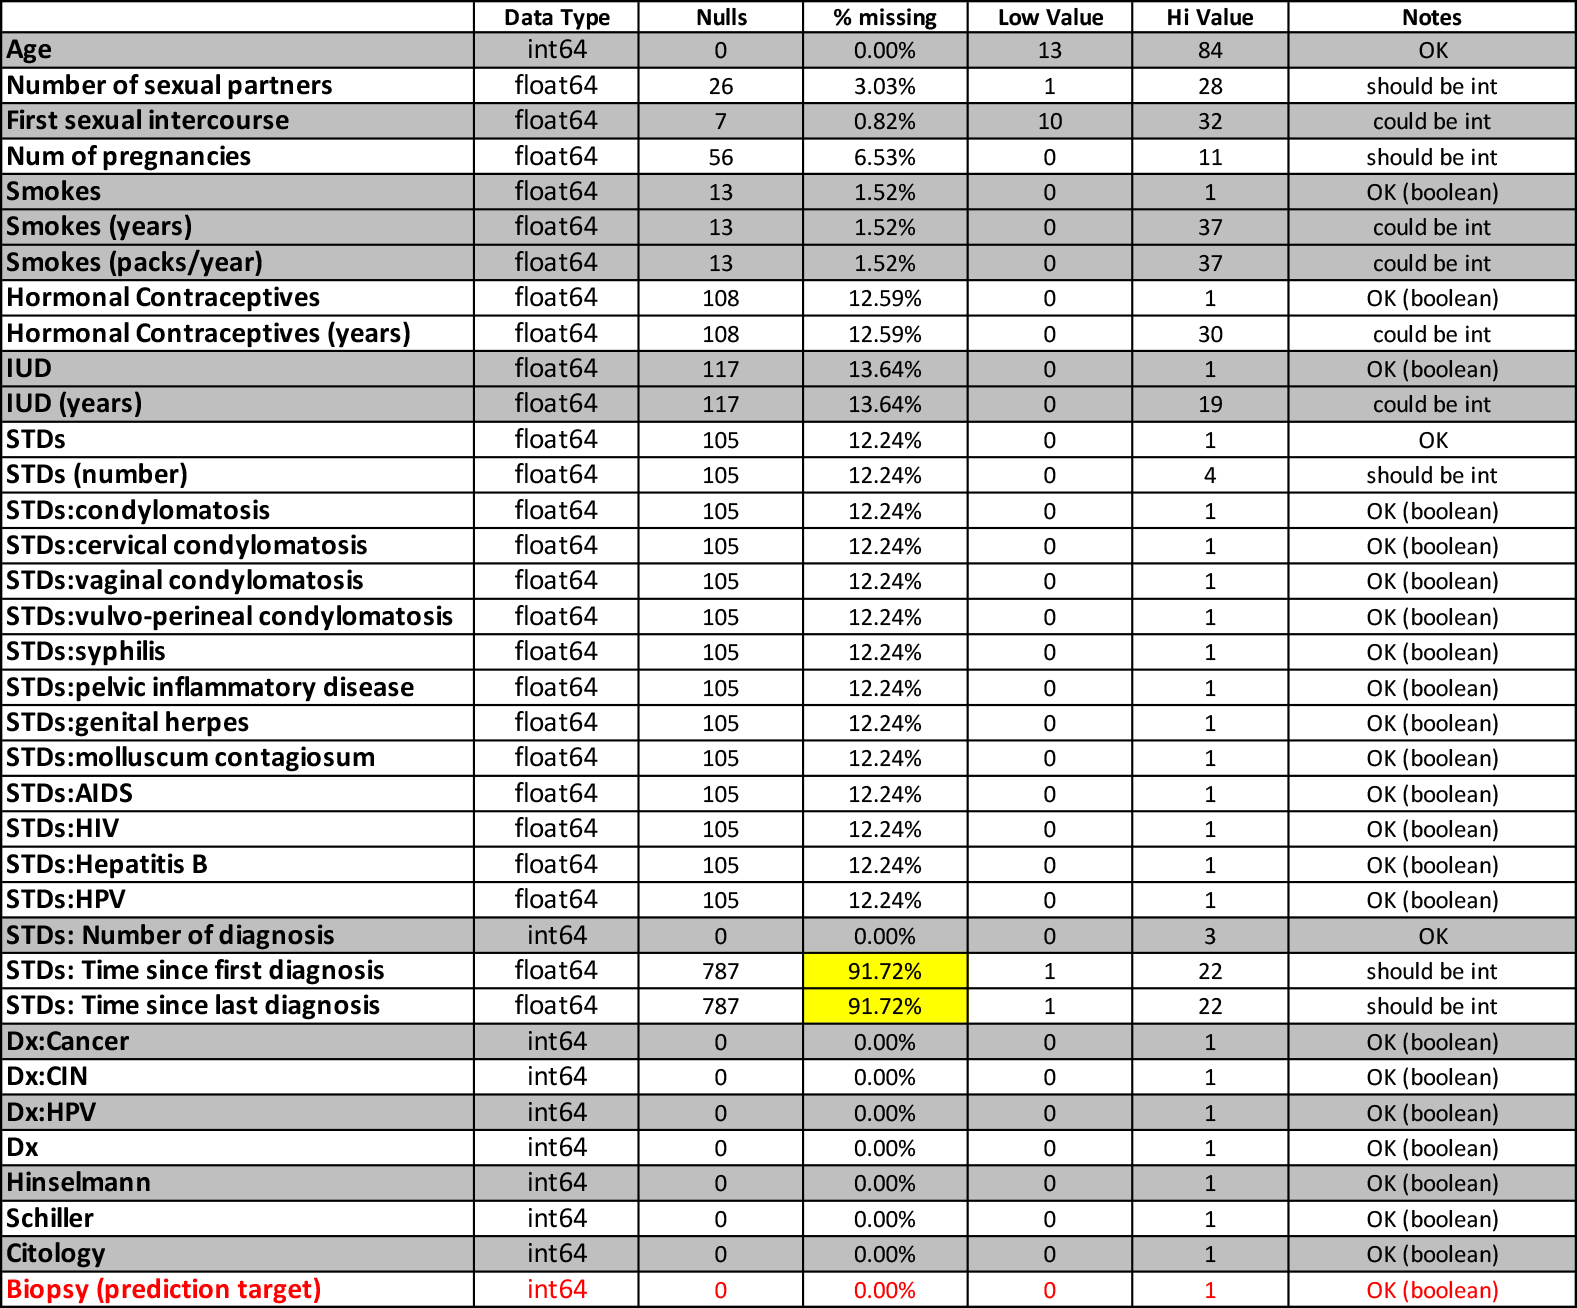

Because I do not want to lose any information that may be present in the records with missing values for these factors:
* Number of sexual partners
* First sexual intercourse
* Num of pregnancies

I chose to create new boolean factors to distinguish between records where the information was known and where no data was given. These factors will have a value of true (1) if the record had a value and a value of false (0) if the record was missing data for that factor:
* is_number_partners_known
* is_first_intercourse_known
* is_number_pregnancies_known


In [8]:
# function to create a new boolean column in a df
# parameters are a dataframe and a column name
# if any value was present for a record in the column provided, the output value will be "1", 
# if the value tests true for pd.isna() the output value will be "0".
# returns a list of values corresponding to each record in the provided dataframe

def new_bool(df, col_name):
    bool_list = []
    for index, row in df.iterrows():
#         print(row)
        value = row[col_name]
#         print(value)
        value_out = 1
        if pd.isna(value):
            value_out = 0
            
#       for testing
#         print("value: {}   -   bool: {}".format(value, str(value_out)))

        bool_list.append(value_out)

    return bool_list


In [9]:
# create new factor 'is_number_partners_known'
df['is_number_partners_known'] = new_bool(df, 'Number of sexual partners')

In [10]:
# check if operation was successful
df['is_number_partners_known'].value_counts(dropna=False)

1    832
0     26
Name: is_number_partners_known, dtype: int64

In [11]:
# create new factor 'is_first_intercourse_known'
df['is_first_intercourse_known'] = new_bool(df, 'First sexual intercourse')

In [12]:
# check if operation was successful
df['is_first_intercourse_known'].value_counts(dropna=False)

1    851
0      7
Name: is_first_intercourse_known, dtype: int64

In [13]:
# create new factor 'is_number_pregnancies_known'
df['is_number_pregnancies_known'] = new_bool(df, 'Num of pregnancies')

In [14]:
# check if operation was successful
df['is_number_pregnancies_known'].value_counts(dropna=False)

1    802
0     56
Name: is_number_pregnancies_known, dtype: int64

Before I delete or fill missing values for any factors I will make another copy of the dataset and continue work on the new copy. This is useful if I ever want or need to revert to the dataset as it exists at this stage.

In [15]:
df2 = df.copy(deep=True)

These factors are missing values for over 90% of the records:
* STDs: Time since first diagnosis
* STDs: Time since last diagnosis

With so many missing values I would typically choose to delete this factor but because there is a "parent" factor related to these two I want to examine the distribution of the "STDs: Number of diagnosis" factor.


In [16]:
df2['STDs: Number of diagnosis'].value_counts(dropna=False)

0    787
1     68
2      2
3      1
Name: STDs: Number of diagnosis, dtype: int64

Over 90% of the records have a zero value for this factor and I am assuming that this means that the patient had never been diagnosed with an STD. Because there may be some useful information in the remaining 71 records that have a values of 1, 2, or 3, I will leave this factor as is. It appears that the 787 records that have a value of zero for this factor are the same 787 records that are missing values for the two "time since..." factors.

In [17]:
# subset the records where the value is zero for 'STDs: Number of diagnosis'
value_zero = df2['STDs: Number of diagnosis'] == 0
temp = df2[value_zero]

print('time since first: ', temp['STDs: Time since first diagnosis'].value_counts(dropna=False))
print('time since last: ', temp['STDs: Time since last diagnosis'].value_counts(dropna=False))

time since first:  NaN    787
Name: STDs: Time since first diagnosis, dtype: int64
time since last:  NaN    787
Name: STDs: Time since last diagnosis, dtype: int64


This confirms that the 787 records missing values for the two "time since..." factors are the same records with a zero for "STDs: Number of diagnosis". I replaced the missing values in these two "time since..." factors with a zero.

In [18]:
df2['STDs: Time since first diagnosis'].fillna(0, inplace=True)
df2['STDs: Time since first diagnosis'].value_counts(dropna=False)

0.0     787
1.0      15
3.0      10
2.0       9
4.0       6
7.0       5
5.0       4
16.0      4
6.0       3
8.0       3
19.0      2
21.0      2
11.0      2
15.0      1
18.0      1
12.0      1
22.0      1
10.0      1
9.0       1
Name: STDs: Time since first diagnosis, dtype: int64

In [19]:
df2['STDs: Time since last diagnosis'].fillna(0, inplace=True)
df2['STDs: Time since last diagnosis'].value_counts(dropna=False)

0.0     787
1.0      17
2.0      10
3.0       9
4.0       6
7.0       5
16.0      4
5.0       3
6.0       3
8.0       3
21.0      2
11.0      2
19.0      1
15.0      1
18.0      1
12.0      1
22.0      1
10.0      1
9.0       1
Name: STDs: Time since last diagnosis, dtype: int64

For the remaining factors with missing factors I created a function that will display a countplot, a boxplot, and some summary stats. This will help with choosing what value to fill missing values in for each factor.


In [20]:
# function to display a countplot, boxplot, and summary stats for a factor

def countplot_boxplot(column, dataframe):
    fig = plt.figure(figsize=(15,20))
    fig.suptitle(column, size=20)
    
    ax1 = fig.add_subplot(2,1,1)
    sns.countplot(dataframe[column])
#     plt.title(column)
    plt.xticks(rotation=45)

    ax2 = fig.add_subplot(2,1,2)
    sns.boxplot(dataframe[column])
#     plt.title(column)
    plt.xticks(rotation=45)
    plt.show()
    
    print('Min:', df2[column].min())
    print('Mean:', df2[column].mean())
    print('Median:', df2[column].median())
    print('Mode:', df2[column].mode()[0])
    print('Max:', df2[column].max())
    print('**********************')
    print('% of values missing:', (df2[column].isna().sum() / len(df2))*100)
 

I created three factors for the various ways I will deal with missing values:
* fillna_median - fills missing values in a factor with the median for that factor
* fillna_mean - fills missing values in a factor with the mean for that factor
* fill_w_value - fills missing values in a factor with a value provided

In [21]:
# function to replace missing values with the median

def fillna_median(column, dataframe):
    dataframe[column].fillna(dataframe[column].median(), inplace=True)
    print (dataframe[column].value_counts(dropna=False))
    
    
# function to replace missing values with the mean

def fillna_mean(column, dataframe):
    dataframe[column].fillna(dataframe[column].mean(), inplace=True)
    print (dataframe[column].value_counts(dropna=False))    


# function to replace missing values with a value provided

def fillna_w_value(value, column, dataframe):
    dataframe[column].fillna(value, inplace=True)
    print(dataframe[column].value_counts(dropna=False))  

The three factors related to smoking are missing values in less than 2% of the records. I will replace the missing values in all three with a zero. I expect this change to have a minimal effect on the models.


In [22]:
col_list = ['Smokes', 'Smokes (years)', 'Smokes (packs/year)']
            
for col in col_list:
    fillna_w_value(0, col, df2)

0.0    735
1.0    123
Name: Smokes, dtype: int64
0.000000     735
1.266973      15
5.000000       9
9.000000       9
1.000000       8
3.000000       7
2.000000       7
7.000000       6
16.000000      6
8.000000       6
4.000000       5
10.000000      5
11.000000      5
6.000000       4
15.000000      4
14.000000      4
0.500000       3
12.000000      3
13.000000      3
19.000000      3
22.000000      2
37.000000      1
34.000000      1
20.000000      1
21.000000      1
18.000000      1
28.000000      1
24.000000      1
32.000000      1
0.160000       1
Name: Smokes (years), dtype: int64
0.000000     735
0.513202      18
1.000000       6
3.000000       5
0.050000       4
2.000000       4
0.750000       4
1.200000       4
0.200000       4
0.100000       3
6.000000       3
12.000000      3
5.000000       3
7.000000       2
0.040000       2
1.350000       2
2.800000       2
1.600000       2
1.400000       2
8.000000       2
2.400000       2
4.500000       2
0.160000       2
3.500000       

Hormonal Contraceptives, IUD, and STDs are boolean factors with about 12-13% of missing values in each. I looked at the distribution of values in each:

In [23]:
col_list = ['Hormonal Contraceptives', 'IUD', 'STDs']

for col in col_list:
    print(col,':')
    print(df2[col].value_counts(dropna=False))
    print("----------------")

Hormonal Contraceptives :
1.0    481
0.0    269
NaN    108
Name: Hormonal Contraceptives, dtype: int64
----------------
IUD :
0.0    658
NaN    117
1.0     83
Name: IUD, dtype: int64
----------------
STDs :
0.0    674
NaN    105
1.0     79
Name: STDs, dtype: int64
----------------


I chose to fill the missing values in each factor with the value (0 or 1) having the highest frequency.

In [24]:
# replace more missing values and confirm results

fillna_w_value(1, 'Hormonal Contraceptives', df2)
fillna_w_value(0, 'IUD', df2)
fillna_w_value(0, 'STDs', df2)


1.0    589
0.0    269
Name: Hormonal Contraceptives, dtype: int64
0.0    775
1.0     83
Name: IUD, dtype: int64
0.0    779
1.0     79
Name: STDs, dtype: int64


The following factors have integer values and all have missing values in 1 to 12% of records:
* Number of sexual partners
* First sexual intercourse
* Num of pregnancies
* Hormonal Contraceptives (years)
* IUD (years)
* STDs (number)

I looked at the distribution of values in each of these factors before deciding how to fill the missing values.

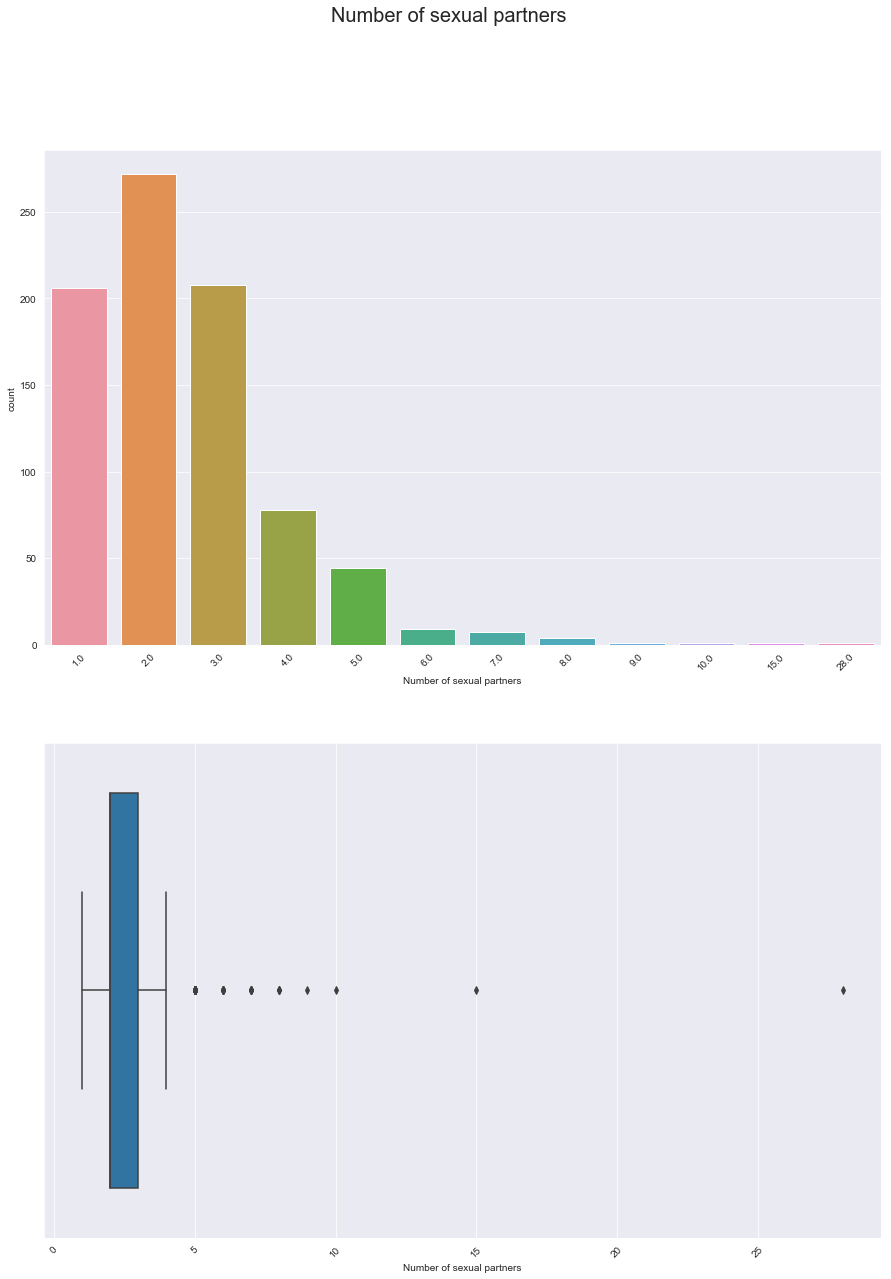

Min: 1.0
Mean: 2.527644230769231
Median: 2.0
Mode: 2.0
Max: 28.0
**********************
% of values missing: 3.0303030303030303


In [25]:
countplot_boxplot('Number of sexual partners', df2)

The mean of 'Number of sexual partners' is pulled higher by some outliers but only 3% of values are missing. I will replace the missing values with 2.0 which is both the mode and the median value.

In [26]:
# replace with median
fillna_median('Number of sexual partners', df2)


2.0     298
3.0     208
1.0     206
4.0      78
5.0      44
6.0       9
7.0       7
8.0       4
9.0       1
28.0      1
10.0      1
15.0      1
Name: Number of sexual partners, dtype: int64


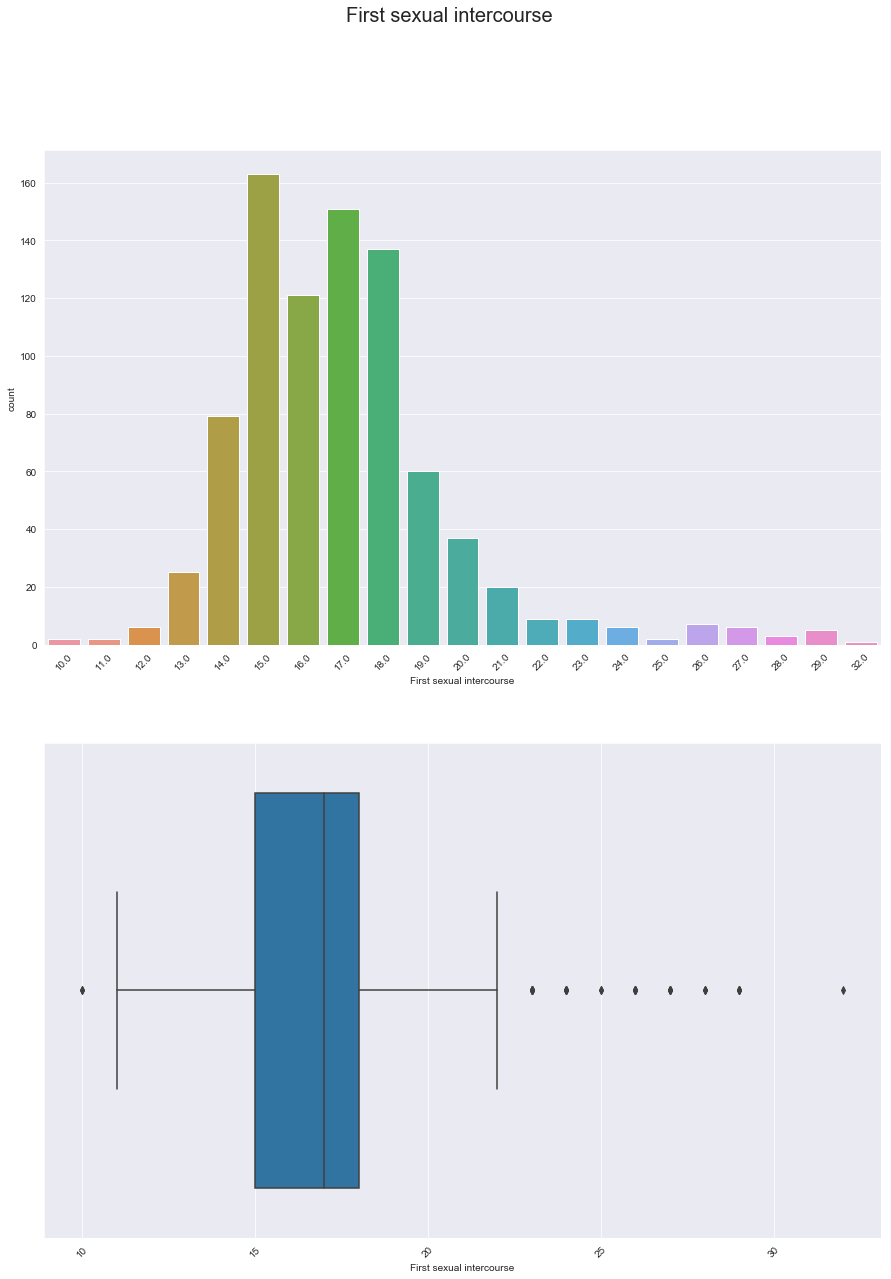

Min: 10.0
Mean: 16.995299647473562
Median: 17.0
Mode: 15.0
Max: 32.0
**********************
% of values missing: 0.8158508158508158


In [27]:
countplot_boxplot('First sexual intercourse', df2)


Less than 1% of values are missing for this factor. I will replace those with the median value.

In [28]:
# replace with median
fillna_median('First sexual intercourse', df2)


15.0    163
17.0    158
18.0    137
16.0    121
14.0     79
19.0     60
20.0     37
13.0     25
21.0     20
22.0      9
23.0      9
26.0      7
27.0      6
24.0      6
12.0      6
29.0      5
28.0      3
25.0      2
11.0      2
10.0      2
32.0      1
Name: First sexual intercourse, dtype: int64


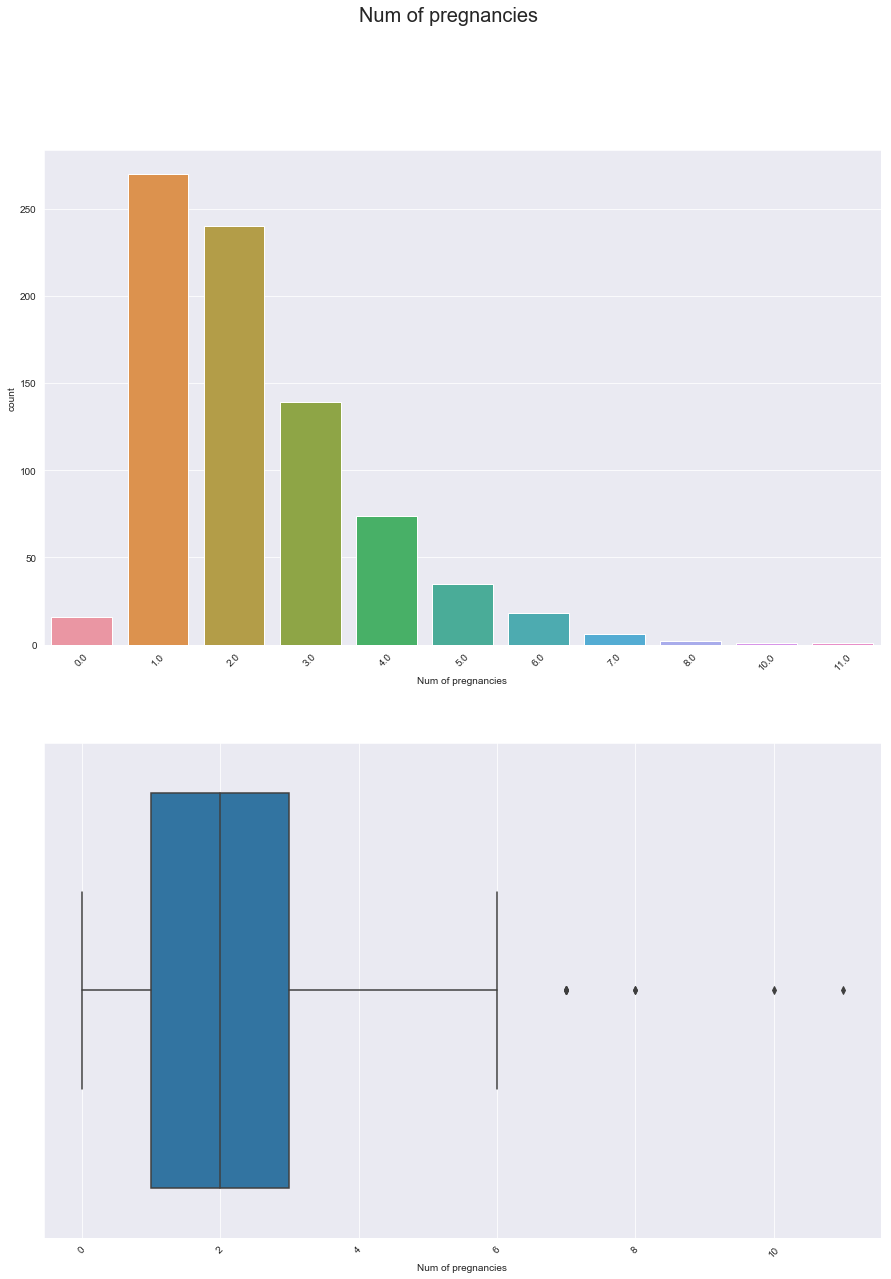

Min: 0.0
Mean: 2.275561097256858
Median: 2.0
Mode: 1.0
Max: 11.0
**********************
% of values missing: 6.526806526806526


In [29]:
countplot_boxplot('Num of pregnancies', df2)

About 6.5% of the values are missing and I will replace those values with the median.

In [30]:
# replace with median
fillna_median('Num of pregnancies', df2)


2.0     296
1.0     270
3.0     139
4.0      74
5.0      35
6.0      18
0.0      16
7.0       6
8.0       2
10.0      1
11.0      1
Name: Num of pregnancies, dtype: int64


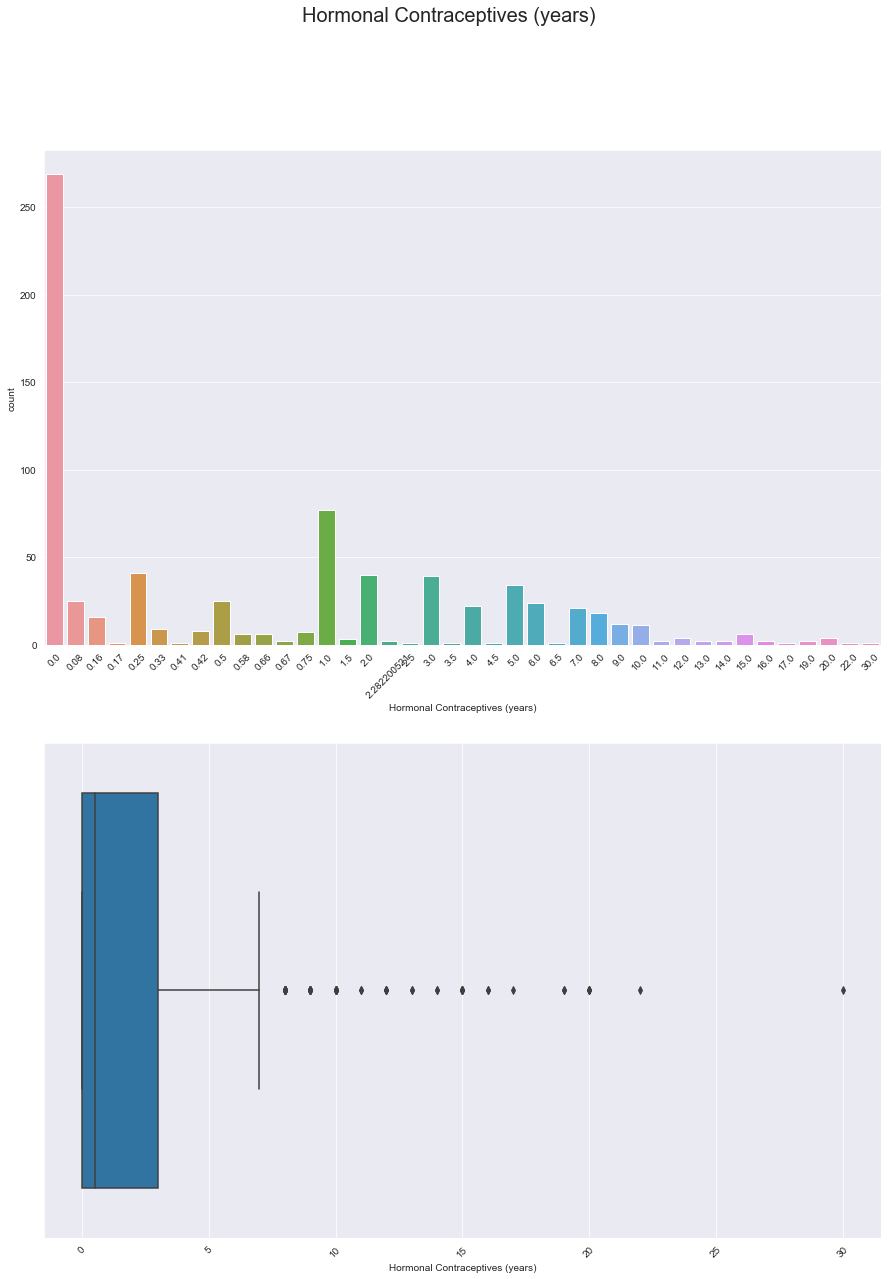

Min: 0.0
Mean: 2.2564192013893343
Median: 0.5
Mode: 0.0
Max: 30.0
**********************
% of values missing: 12.587412587412588


In [31]:
countplot_boxplot('Hormonal Contraceptives (years)', df2)

About 12.6% of the records are missing values for this factor and records with a zero value are by far the largest group. There are quite a few outliers, all falling in the higher value range. These high outliers pull the mean substantially higher than the median. An argument could be made to fill the missing values with either the mode (0) or the median (0.5). I chose to fill them with the mode (0).

In [32]:
# replace with zeros
fillna_w_value(0,'Hormonal Contraceptives (years)', df2)


0.000000     377
1.000000      77
0.250000      41
2.000000      40
3.000000      39
5.000000      34
0.500000      25
0.080000      25
6.000000      24
4.000000      22
7.000000      21
8.000000      18
0.160000      16
9.000000      12
10.000000     11
0.330000       9
0.420000       8
0.750000       7
0.580000       6
15.000000      6
0.660000       6
20.000000      4
12.000000      4
1.500000       3
19.000000      2
0.670000       2
11.000000      2
14.000000      2
13.000000      2
16.000000      2
2.282201       2
0.170000       1
22.000000      1
2.500000       1
4.500000       1
6.500000       1
3.500000       1
30.000000      1
17.000000      1
0.410000       1
Name: Hormonal Contraceptives (years), dtype: int64


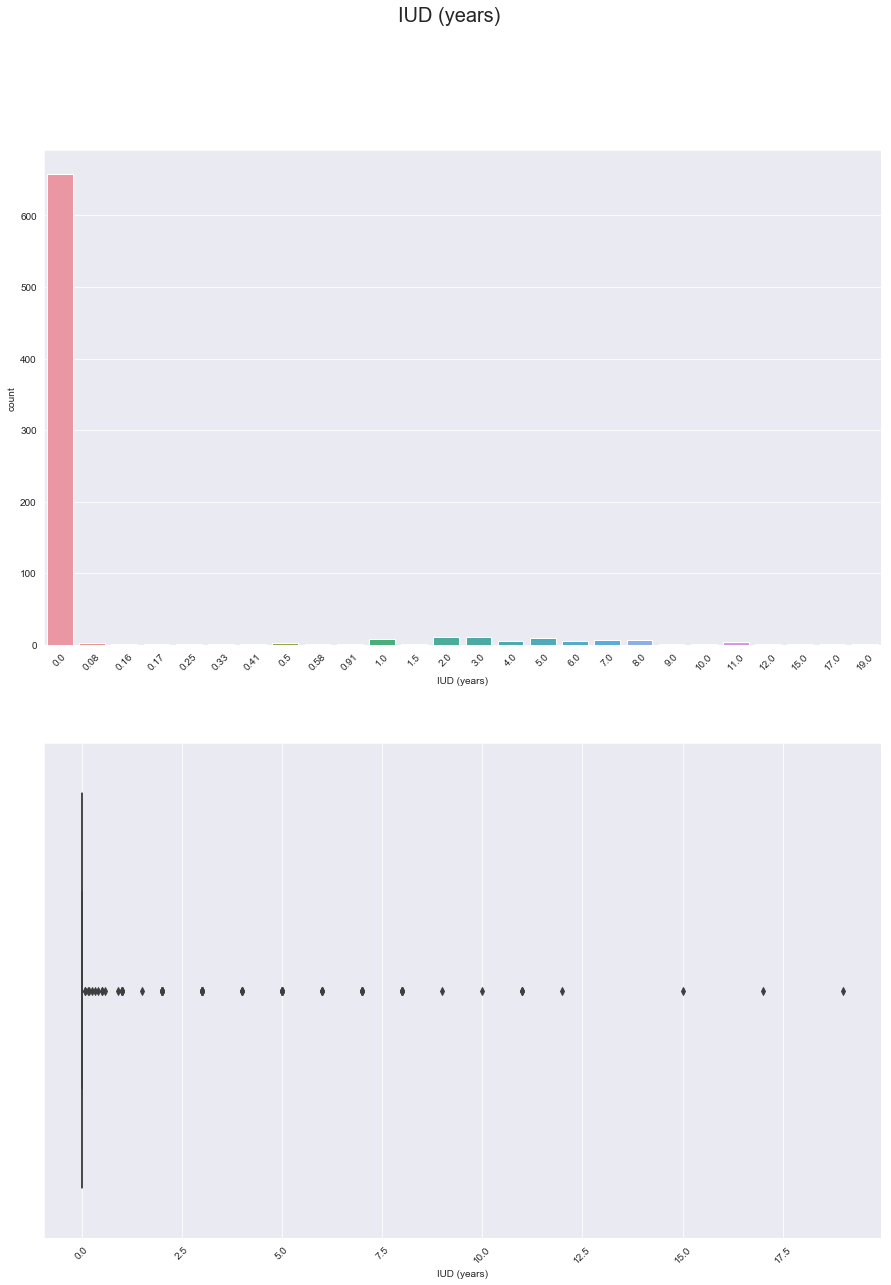

Min: 0.0
Mean: 0.514804318488529
Median: 0.0
Mode: 0.0
Max: 19.0
**********************
% of values missing: 13.636363636363635


In [33]:
countplot_boxplot('IUD (years)', df2)

This factor has over 13% missing values and zero occurrs in an overwhelming majority of the records. I chose to fill the missing values with zero.

In [34]:
# replace with zeros
fillna_w_value(0, 'IUD (years)', df2)


0.00     775
3.00      11
2.00      10
5.00       9
1.00       8
7.00       7
8.00       7
6.00       5
4.00       5
11.00      3
0.50       2
0.08       2
12.00      1
15.00      1
9.00       1
0.33       1
10.00      1
0.25       1
17.00      1
19.00      1
1.50       1
0.17       1
0.41       1
0.58       1
0.91       1
0.16       1
Name: IUD (years), dtype: int64


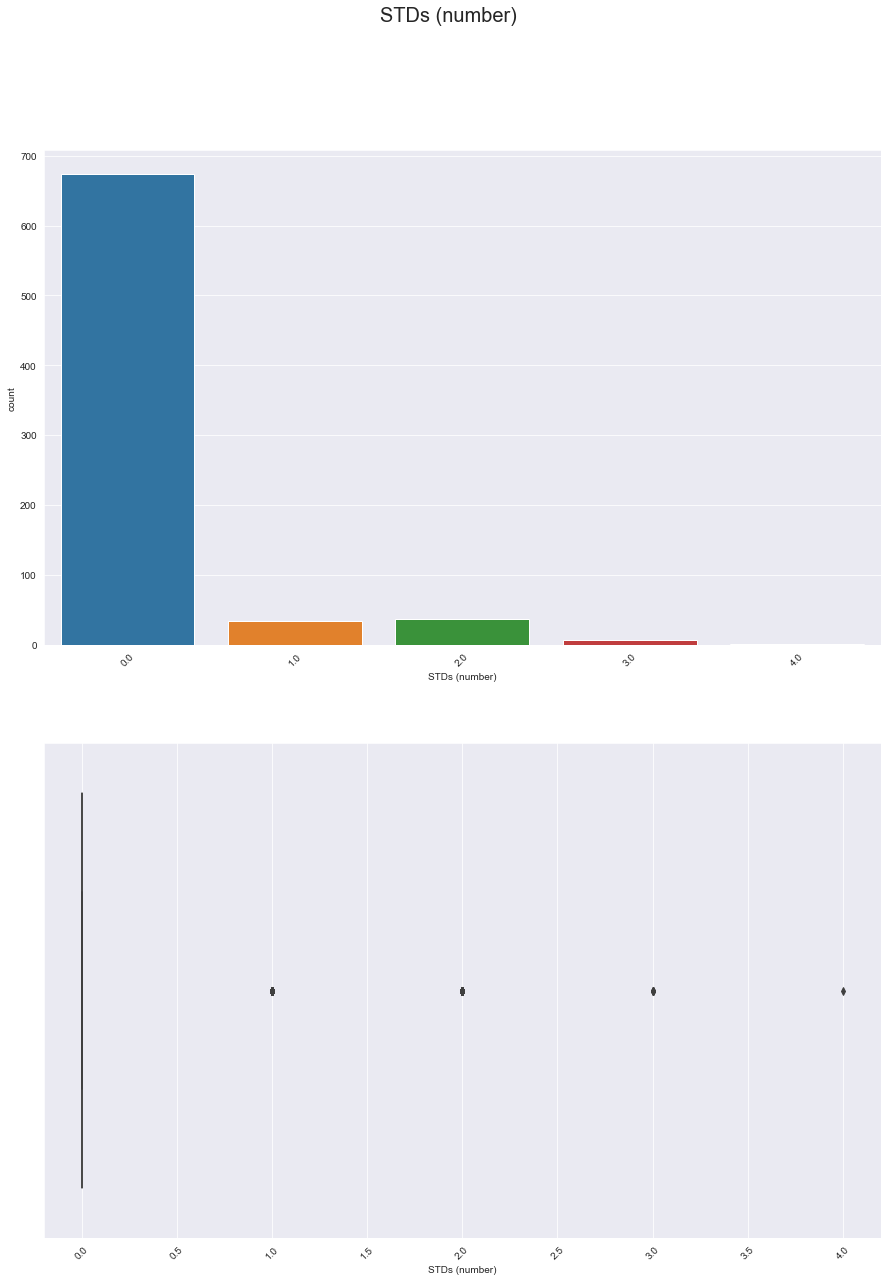

Min: 0.0
Mean: 0.17662682602921648
Median: 0.0
Mode: 0.0
Max: 4.0
**********************
% of values missing: 12.237762237762238


In [35]:
countplot_boxplot('STDs (number)', df2)

I chose to replace the approximately 12% of missing values in this factor with zeros because zero is again the overwhelmingly most common value.


In [36]:
# replace with zeros
fillna_w_value(0, 'STDs (number)', df2)


0.0    779
2.0     37
1.0     34
3.0      7
4.0      1
Name: STDs (number), dtype: int64


There are 12 individual boolean factors, each for a different STD. Each has about 12% missing values. Because I replaced the missing values in the "STDs (number)" factor with zeros, I will also replace the missing values in each of these factors with zero.

In [37]:
# replace missing values with a zero
col_list = [
    'STDs:condylomatosis',
    'STDs:cervical condylomatosis',
    'STDs:vaginal condylomatosis',
    'STDs:vulvo-perineal condylomatosis',
    'STDs:syphilis',
    'STDs:pelvic inflammatory disease',
    'STDs:genital herpes',
    'STDs:molluscum contagiosum',
    'STDs:AIDS',
    'STDs:HIV',
    'STDs:Hepatitis B',
    'STDs:HPV']


for col in col_list:
    fillna_w_value(0, col, df2)


0.0    814
1.0     44
Name: STDs:condylomatosis, dtype: int64
0.0    858
Name: STDs:cervical condylomatosis, dtype: int64
0.0    854
1.0      4
Name: STDs:vaginal condylomatosis, dtype: int64
0.0    815
1.0     43
Name: STDs:vulvo-perineal condylomatosis, dtype: int64
0.0    840
1.0     18
Name: STDs:syphilis, dtype: int64
0.0    857
1.0      1
Name: STDs:pelvic inflammatory disease, dtype: int64
0.0    857
1.0      1
Name: STDs:genital herpes, dtype: int64
0.0    857
1.0      1
Name: STDs:molluscum contagiosum, dtype: int64
0.0    858
Name: STDs:AIDS, dtype: int64
0.0    840
1.0     18
Name: STDs:HIV, dtype: int64
0.0    857
1.0      1
Name: STDs:Hepatitis B, dtype: int64
0.0    856
1.0      2
Name: STDs:HPV, dtype: int64


In the list above it is apparent that two of these 12 factors have no information:
* STDs:cervical condylomatosis
* STDs:AIDS

I dropped them from the dataframe.

In [38]:
# drop useless factors
df2.drop(['STDs:cervical condylomatosis','STDs:AIDS'], axis=1, inplace=True)

In [39]:
# look for any remaining NaN's in the dataframe
df2.isna().sum()

Age                                   0
Number of sexual partners             0
First sexual intercourse              0
Num of pregnancies                    0
Smokes                                0
Smokes (years)                        0
Smokes (packs/year)                   0
Hormonal Contraceptives               0
Hormonal Contraceptives (years)       0
IUD                                   0
IUD (years)                           0
STDs                                  0
STDs (number)                         0
STDs:condylomatosis                   0
STDs:vaginal condylomatosis           0
STDs:vulvo-perineal condylomatosis    0
STDs:syphilis                         0
STDs:pelvic inflammatory disease      0
STDs:genital herpes                   0
STDs:molluscum contagiosum            0
STDs:HIV                              0
STDs:Hepatitis B                      0
STDs:HPV                              0
STDs: Number of diagnosis             0
STDs: Time since first diagnosis      0


All missing values have now been dealt with. 

***

## Exploratory Data Analysis

I will first look at a heatmap to see if any factors show obvious colinearity.

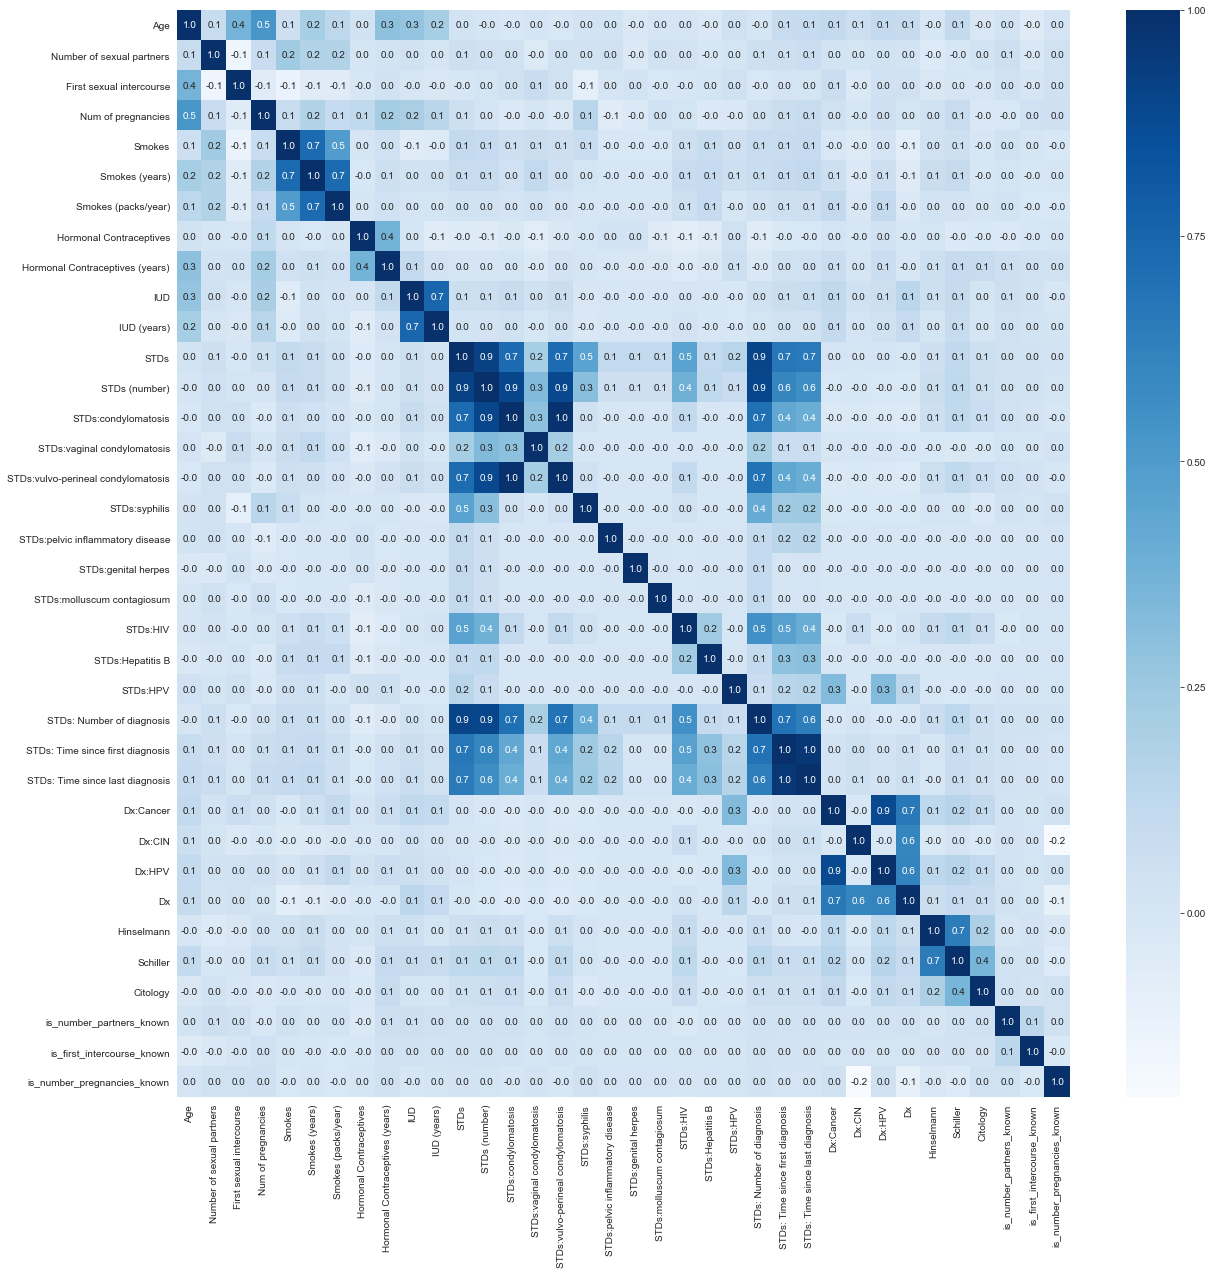

In [40]:
# pull the target variable from the dataframe and use a heatmap to look at possible correlations between factors
temp_df = df2.drop('Biopsy', axis=1)
f,ax = plt.subplots(figsize=(20,20))
sns.heatmap(temp_df.loc[:,:].corr(), annot=True, cmap="Blues", fmt='.1f' )
plt.show()

Soem factors show strong correlation but this is not surprising. 

For example, "STDs", "STDs (number)", and "STDs: Number of diagnosis", all show signifigant correlations to the individual STD factors and this would be expected.

Additionally, the following factors all show some correlation with age:
* Number of sexual partners
* First sexual intercourse
* Number of pregnancies
* Smokes (years)
* Hormonal Contraceptives (years)
* IUD
* IUD (years)

It is not surprising that these factors would be correlated with a patients age.


Next I looked how factors correlated to the target variable (Biopsy). I chose to look at the top 12 factors (ranked by correlation to Biopsy).

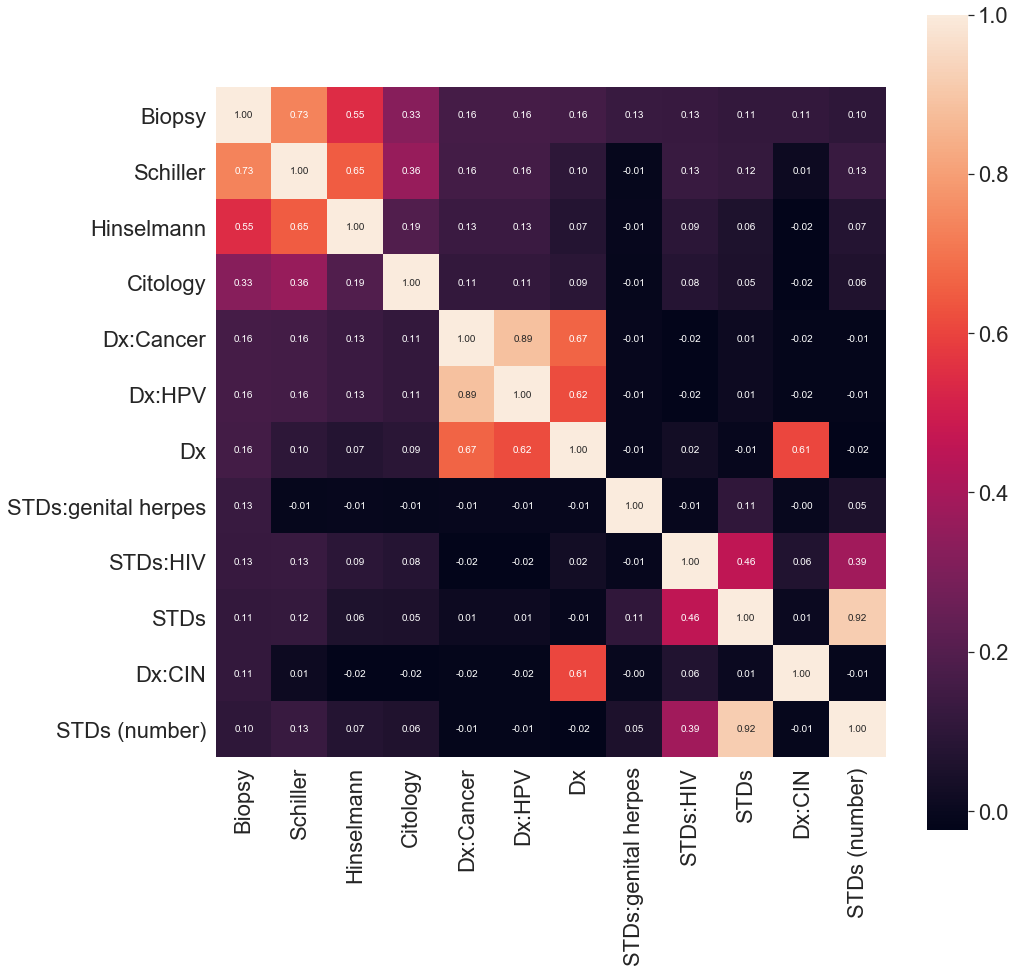

In [41]:
# look at a correlation matrix of the top 12 factors to the target variable: Biopsy

corrmat = df2.corr()
k = 12 #number of variables for heatmap
cols = corrmat.nlargest(k, 'Biopsy')['Biopsy'].index
cm = np.corrcoef(df2[cols].values.T)

plt.figure(figsize=(15,15))

sns.set(font_scale=2)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10},
                 yticklabels = cols.values, xticklabels = cols.values)
plt.show()

Schiller, Hinselmann, and Citology are factors representing medical diagnostic tools used to identify cervical cancer. It's not surprising they have the strongest correlations with Biopsy.

In [42]:
# make a backup copy of df2 at this stage of processing
df_backup = df2.copy()

***

# Training and Testing Machine Learning Models

First step: Seperate the dataset into the predictive factors and the target variable 

In [43]:
# create X and y
X = df2.drop(['Biopsy'], axis=1)

y = df2['Biopsy']


In [44]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 858 entries, 0 to 857
Data columns (total 36 columns):
Age                                   858 non-null int64
Number of sexual partners             858 non-null float64
First sexual intercourse              858 non-null float64
Num of pregnancies                    858 non-null float64
Smokes                                858 non-null float64
Smokes (years)                        858 non-null float64
Smokes (packs/year)                   858 non-null float64
Hormonal Contraceptives               858 non-null float64
Hormonal Contraceptives (years)       858 non-null float64
IUD                                   858 non-null float64
IUD (years)                           858 non-null float64
STDs                                  858 non-null float64
STDs (number)                         858 non-null float64
STDs:condylomatosis                   858 non-null float64
STDs:vaginal condylomatosis           858 non-null float64
STDs:vulvo-p

In [45]:
y.head()

0    0
1    0
2    0
3    0
4    0
Name: Biopsy, dtype: int64

In [46]:
# create an 80/20 train/test split with a specified random value for reproducibility

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state= 10)


Next: Standardization and normalization 
If there is a difference in the range of values between factors, many machine learning models will not properly compensate for these differences and this can negatively impact a models' performance. None of the numeric factors in this dataset:
* Age
* Number of sexual partners
* First sexual intercourse
* Num of pregnancies
* Smokes (years)
* Smokes (packs/years)
* Hormonal Contraceptives (years)
* IUD (years)
* STDs (number)
* STD's (number of diagnosis)
* STDs: Time since first diagnosis
* STDs: Time since last diagnosis

have a normal distribution. Only "Age" is remotely "normal". Accordingly I am choosing to standardize all of these factors into a range from zero to 1. Standardization is done AFTER the test/train split so that the training data does not have the advantage of any information from the testing data.

In [47]:
# standardize the continuous factors

minmax_scale = preprocessing.MinMaxScaler(feature_range=(0, 1))

X_train = pd.DataFrame(minmax_scale.fit_transform(X_train), columns = X.columns)
X_test = pd.DataFrame(minmax_scale.fit_transform(X_test), columns = X.columns)


Confirm that X and Y for both test and train sets have the same number of records.

In [48]:
print(X_train.shape)
print(y_train.shape)

(686, 36)
(686,)


In [49]:
print(X_test.shape)
print(y_test.shape)

(172, 36)
(172,)


Now look at the value counts for the target variable.

In [50]:
y_train.value_counts()

0    647
1     39
Name: Biopsy, dtype: int64

In [51]:
y_test.value_counts()

0    156
1     16
Name: Biopsy, dtype: int64

In both the test and train sets, the true value (1) is a small percentage of the total records. This creates an "unbalanced" dataset and makes prediction with machine learning models more difficult. Varying ways of addressing this scenario exist and some machine learning models include parameters specifically designed to improve performance with unbalanced datasets. Libraries have been developed that create new "fictitous" samples of an underrepresented class (or classes) based on the "real" examples from a class. 

I will experiment with a few options to address the unbalanced data in some of the models. 

I chose to explore the following models:
* Logistic Regression
* KNN ( K Nearest Neighbors)
* Decision Tree
* Random Forest
* SVM

## Creating an additional test/train dataset with "synthetic" training samples

As mentioned above, one of the strategies that I will test is 'over-sampling' - creating new, fictitous samples such that the target variable in the training data is balanced between the two classes (True/False). The target variable in the original dataset ("Biopsy") is very unbalanced with about 90% of the samples being False. Oversampling will be used to create new samples such that the training data target variable will be equally distributed between True and False values. The oversampling library I will be using is 'SMOTE' from the imbalanced-learn project (https://imbalanced-learn.readthedocs.io/en/stable/index.html). SMOTE is an acronym for Synthetic Minority Over-sampling Technique. 



In [52]:
# using SMOTE to create a balanced training dateset
sm = SMOTE(sampling_strategy='auto', random_state=10)

X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

In [53]:
X_train.shape

(686, 36)

In [54]:
X_train_res.shape

(1294, 36)

In [55]:
y_train.shape

(686,)

In [56]:
y_train_res.shape

(1294,)

In [57]:
unique_elements, counts_elements = np.unique(y_train_res, return_counts=True)
print("Frequency of unique values :")
print(np.asarray((unique_elements, counts_elements)))

Frequency of unique values :
[[  0   1]
 [647 647]]


Now I also have a balanced dataset to test with (X_train_res, y_train_res)

***

## Machine Learning Models

Because this project is attempting to predict the presenct of a life-threatening illness, it is preferable to not miss any positives (cancer present), even if that means getting more false positives (predict patient has cancer when she does not).

Preference in scoring will be given to models with high recall (the percentage of patients with cancer that the model captures). A higher false positive rate (model predicted cancer, but no cancer present) will be tolerated to achieve higher recall.  

In [58]:
# create a function to display a graph of precision and recall and the scores I am interested in

def analysis(model, X_train, y_train):
    model.fit(X_train, y_train)

    # predict probabilities
    probs = model.predict_proba(X_test)

    # keep probabilities for the positive outcome only
    probs = probs[:, 1]

    # predict class values
    preds = model.predict(X_test)

    # calculate precision-recall curve
    precision, recall, thresholds = precision_recall_curve(y_test, probs)

    # calculate average precision
    average_precision = average_precision_score(y_test, probs)
    
    # recall score for class 1 (Predict that Biopsy is True)
    rs = recall_score(y_test, preds)
    

    # calculate F1 score
    f1 = f1_score(y_test, preds)

    # calculate precision-recall AUC
    auc_score = auc(recall, precision)
    

    # create chart
    # In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
    step_kwargs = ({'step': 'post'}
                   if 'step' in signature(plt.fill_between).parameters
                   else {})
    plt.step(recall, precision, color='b', alpha=0.2, where='post')
    plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

    # plot a "no skill" line
    plt.plot([0, 1], [0.5, 0.5], linestyle='--')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('Precision-Recall curve: Average Precision={0:0.3f}'.format(average_precision))
    plt.show()

    # print(confusion_matrix(y_test, preds))
    print('Classification Report:')
    print(classification_report(y_test, preds))

    print('f1=%.3f auc=%.3f recall=%.3f' % (f1, auc_score, rs))
    
    
    
    
#     print()
#     print('**************************************** Original chart:')


#     # plot a "no skill" line
#     plt.plot([0, 1], [0.5, 0.5], linestyle='--')


#     # plot the precision-recall curve for the model
#     plt.plot(recall, precision, marker='.')
#     plt.xlabel('recall')
#     plt.ylabel('precision')

#     # show the plot
#     plt.show()
    

In [59]:
# function to plot the importances of factors used in a model
def plot_feature_importances(model):
    n_features = X_train.shape[1]
    plt.figure(figsize=(15,15))
    plt.barh(range(n_features), model.feature_importances_, align='center') 
    plt.yticks(np.arange(n_features), X.columns)
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")


### Logistic Regression

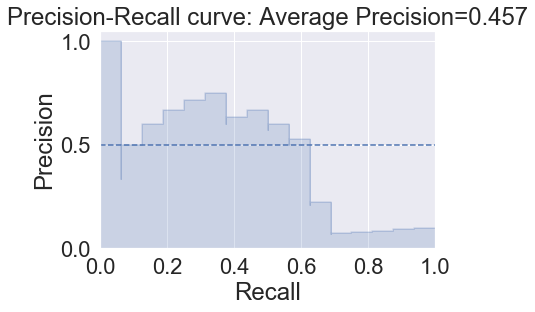

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.90      0.93       156
           1       0.40      0.62      0.49        16

    accuracy                           0.88       172
   macro avg       0.68      0.76      0.71       172
weighted avg       0.91      0.88      0.89       172

f1=0.488 auc=0.439 recall=0.625


In [60]:
# logistic regression model with no adjustment for unbalanced class of target variable

model = LogisticRegression(fit_intercept = False,
                                C = 1e12,
                                class_weight='None',
                                solver='lbfgs',
                               max_iter = 4000)

analysis(model, X_train, y_train)


F1 score of below .5 is no better than random guessing.

I then tried this model using the class_weight parameter set to 'balanced' to compensate for the unbalanced data.

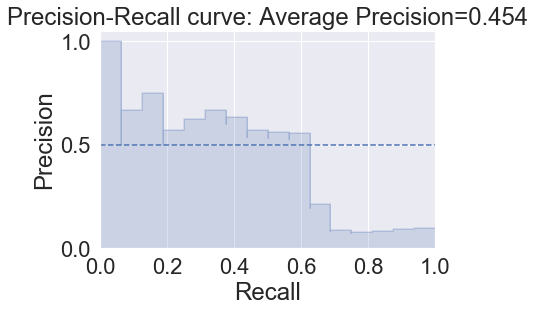

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.88      0.92       156
           1       0.34      0.62      0.44        16

    accuracy                           0.85       172
   macro avg       0.65      0.75      0.68       172
weighted avg       0.90      0.85      0.87       172

f1=0.444 auc=0.435 recall=0.625


In [61]:
# logistic regression model using class_weight-balanced argument
model = LogisticRegression(fit_intercept = False,
                                C = 1e12,
                                class_weight='balanced',
                                solver='lbfgs',
                               max_iter = 4000)

analysis(model, X_train, y_train)

Using the 'balanced' option for the class_weight parameter resulted in even lower recall and F1 scores.

Next, try it with the resampled data.

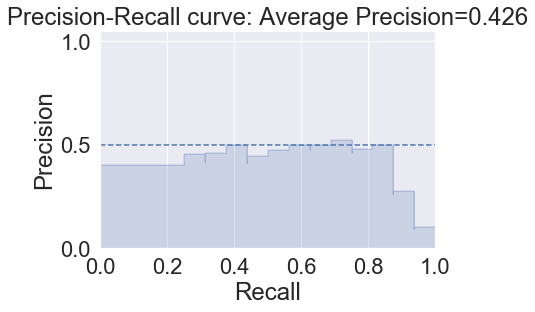

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.83      0.90       156
           1       0.35      0.88      0.50        16

    accuracy                           0.84       172
   macro avg       0.67      0.85      0.70       172
weighted avg       0.93      0.84      0.87       172

f1=0.500 auc=0.491 recall=0.875


In [62]:
# logistic regression model using class_weight-balanced argument
model = LogisticRegression(fit_intercept = False,
                                C = 1e12,
                                solver='lbfgs',
                               max_iter = 4000)

analysis(model, X_train_res, y_train_res)

Using the balanced dataset the recall improved substantially but the F1 score is still very poor and this model is no better than guessing.

## KNN
K nearest neighbors models typically do not work well with unbalanced data like this. I will try the model with n_neighbors=1. Then I will employ a different sampling method to create a "syntheticaly" balanced dataset.

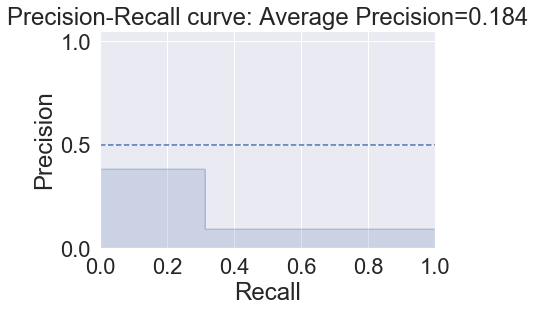

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.95      0.94       156
           1       0.38      0.31      0.34        16

    accuracy                           0.89       172
   macro avg       0.66      0.63      0.64       172
weighted avg       0.88      0.89      0.88       172

f1=0.345 auc=0.381 recall=0.312


In [63]:
# KNN
model = KNeighborsClassifier(n_neighbors=1)

analysis(model, X_train, y_train)

As expected this model performs very poorly. Again as recall increases, precision plummets.

Now trying with the resampled data.

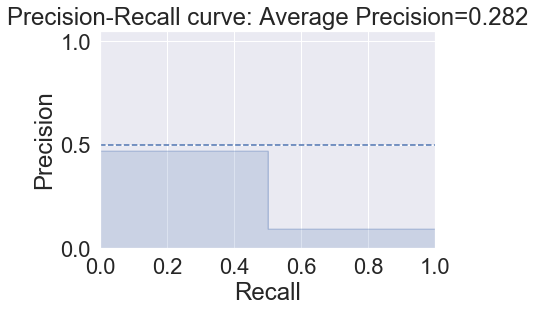

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.94      0.95       156
           1       0.47      0.50      0.48        16

    accuracy                           0.90       172
   macro avg       0.71      0.72      0.72       172
weighted avg       0.90      0.90      0.90       172

f1=0.485 auc=0.509 recall=0.500


In [64]:
# KNN
model = KNeighborsClassifier(n_neighbors=1)

analysis(model, X_train_res, y_train_res)

A signicant improvement but still very poor performance.

## Decision Tree

I will employ grid search to experiment with different values for some of the parameters of a decision tree.

In [65]:
# create a Decision Tree 
tree_clf = DecisionTreeClassifier(random_state=10) 

# create a parameter grid
dt_param_grid = {
    'class_weight': ['balanced'],
    'criterion': ['gini', 'entropy'],
    'max_depth': [2, 3, 4, 5, 6, 7]}

dt_grid_search = GridSearchCV(tree_clf, 
                              param_grid = dt_param_grid, 
                              scoring = 'recall',
                              cv=3, 
                              return_train_score=True)

In [66]:
dt_grid_search.fit(X_train, y_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=DecisionTreeClassifier(class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort=False, random_state=10,
                                              splitter='best'),
             iid='warn', n_jobs=None,
             param_grid={'class_weight': ['balanced'],
                         'criterion': ['gini', 'entropy'],
                        

In [67]:
dt_gs_training_score = np.mean(dt_grid_search.cv_results_['mean_train_score'])
dt_gs_testing_score = dt_grid_search.score(X_test, y_test)

print("Mean Training Score: {:.4}%".format(dt_gs_training_score * 100))
print("Mean Testing Score: {:.4}%".format(dt_gs_testing_score * 100))
print("Best Parameter Combination Found During Grid Search:")
dt_grid_search.best_params_

Mean Training Score: 98.08%
Mean Testing Score: 87.5%
Best Parameter Combination Found During Grid Search:


{'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 2}

Now I will create a decision tree using the best values determined by grid search.

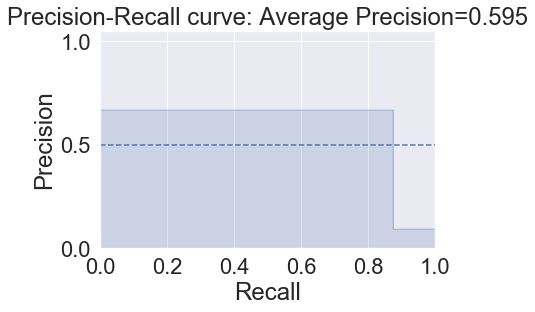

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.94      0.96       156
           1       0.61      0.88      0.72        16

    accuracy                           0.94       172
   macro avg       0.80      0.91      0.84       172
weighted avg       0.95      0.94      0.94       172

f1=0.718 auc=0.773 recall=0.875


In [68]:
tree = DecisionTreeClassifier(class_weight = 'balanced', criterion = "gini", max_depth = 2, random_state=10) 

analysis(tree, X_train, y_train)



Best performance so far. 

Look at the feature importances for this tree.




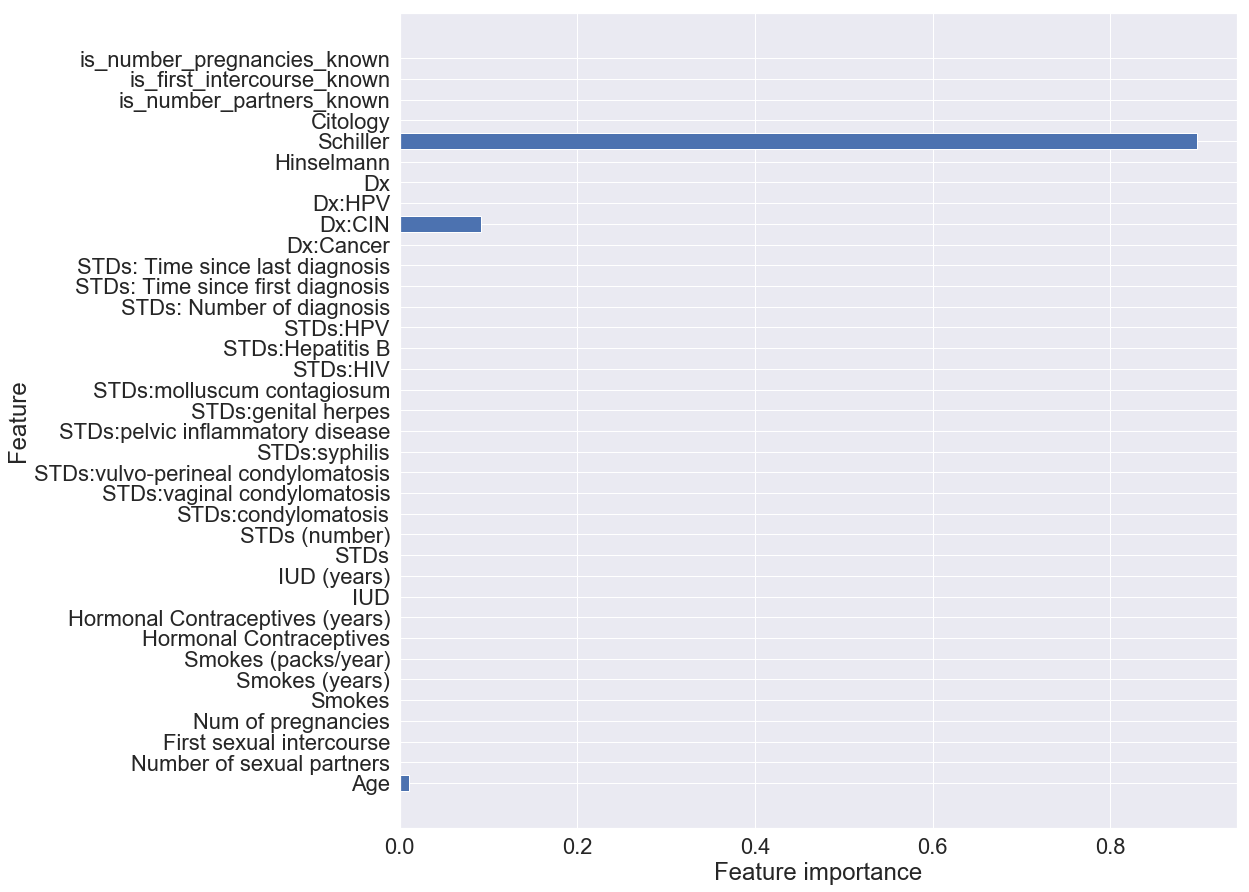

In [69]:
plot_feature_importances(tree)
plt.show()

Now try using the resampled data.

In [70]:
# use grid search again, but with the resampled data
# create a Decision Tree 
tree_clf = DecisionTreeClassifier(random_state=10) 

# create a parameter grid
dt_param_grid = {
    'class_weight': [None],
    'criterion': ['gini', 'entropy'],
    'max_depth': [2, 3, 4, 5, 6, 7]}

dt_grid_search = GridSearchCV(tree_clf, 
                              param_grid = dt_param_grid, 
                              scoring = 'recall',
                              cv=3, 
                              return_train_score=True)

dt_grid_search.fit(X_train_res, y_train_res)

GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=DecisionTreeClassifier(class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort=False, random_state=10,
                                              splitter='best'),
             iid='warn', n_jobs=None,
             param_grid={'class_weight': [None],
                         'criterion': ['gini', 'entropy'],
                         'max_

In [71]:
dt_gs_training_score = np.mean(dt_grid_search.cv_results_['mean_train_score'])
dt_gs_testing_score = dt_grid_search.score(X_test, y_test)

print("Mean Training Score: {:.4}%".format(dt_gs_training_score * 100))
print("Mean Testing Score: {:.4}%".format(dt_gs_testing_score * 100))
print("Best Parameter Combination Found During Grid Search:")
dt_grid_search.best_params_

Mean Training Score: 99.23%
Mean Testing Score: 56.25%
Best Parameter Combination Found During Grid Search:


{'class_weight': None, 'criterion': 'entropy', 'max_depth': 6}

Create a tree using these parameters

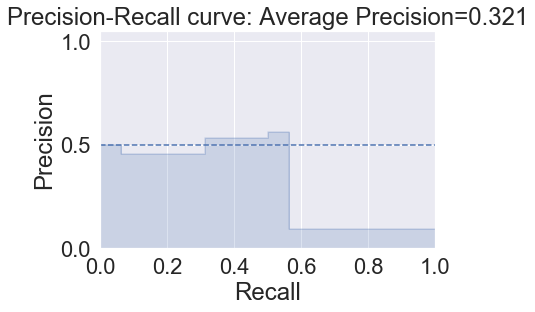

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.96      0.96       156
           1       0.56      0.56      0.56        16

    accuracy                           0.92       172
   macro avg       0.76      0.76      0.76       172
weighted avg       0.92      0.92      0.92       172

f1=0.562 auc=0.417 recall=0.562


In [72]:
tree = DecisionTreeClassifier(criterion = "entropy", max_depth = 6, random_state=10) 

analysis(tree, X_train_res, y_train_res)


Both recall and F1 scores are lower using the resampled data.

I want to see what features are most important in this decision tree.

It's not surprising that "Schilller" is by far the most important feature as it represents a diagnostic test to determine the presence of this cancer.

## Random Forest

I used grid search to search for the best parameters when creating a random forest. I chose "recall" for the scoring measurement and 3 for cross-validation folds.

In [73]:
# use grid search for the random forest classifier, use recall as the factor to optimize
forest = RandomForestClassifier(random_state=10, n_jobs=-1)

forest_param_grid = {
    'class_weight': ['balanced'],
    'criterion': ['gini', 'entropy' ],
    'max_depth': [2, 3, 4, 5, 6, 7, 8],
    'n_estimators': [20, 40, 50, 60, 80, 100, 200]}

forest_grid_search = GridSearchCV(forest, 
                                  param_grid = forest_param_grid, 
                                  scoring = 'recall',
                                  cv=3,
                                  return_train_score=True)

In [74]:
import time
start = time.time()

forest_grid_search.fit(X_train, y_train)

print("Testing Accuracy: {:.4}%".format(forest_grid_search.best_score_ * 100))
print("Total Runtime for Grid Search on Random Forest Classifier: {:.4} seconds".format(time.time() - start))
print("")
print("Optimal Parameters: {}".format(forest_grid_search.best_params_))


Testing Accuracy: 87.18%
Total Runtime for Grid Search on Random Forest Classifier: 85.01 seconds

Optimal Parameters: {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 2, 'n_estimators': 20}


/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Based on these results, I attempted to fine-tune some of the parameters by creating a new grid search.

In [75]:
forest_param_grid = {
    'class_weight': ['balanced'],
    'criterion': ['gini'],
    'max_depth': [2, 3, 4],
    'n_estimators': [10, 15, 20, 25, 30]}

forest_grid_search = GridSearchCV(forest, 
                                  param_grid = forest_param_grid, 
                                  scoring = 'recall',
                                  cv=3,
                                  return_train_score=True)

In [76]:
import time
start = time.time()

forest_grid_search.fit(X_train, y_train)

print("Testing Accuracy: {:.4}%".format(forest_grid_search.best_score_ * 100))
print("Total Runtime for Grid Search on Random Forest Classifier: {:.4} seconds".format(time.time() - start))
print("")
print("Optimal Parameters: {}".format(forest_grid_search.best_params_))


Testing Accuracy: 87.18%
Total Runtime for Grid Search on Random Forest Classifier: 10.83 seconds

Optimal Parameters: {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 2, 'n_estimators': 10}


Now using the values obtained I will create a new random forest.

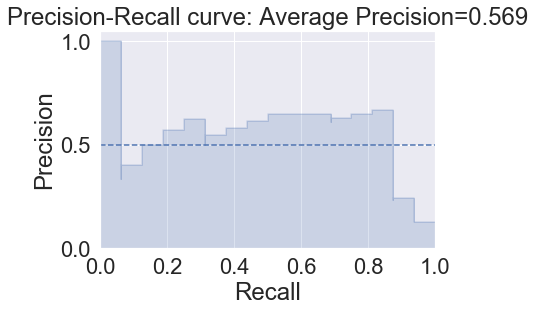

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.96      0.97       156
           1       0.67      0.88      0.76        16

    accuracy                           0.95       172
   macro avg       0.83      0.92      0.86       172
weighted avg       0.96      0.95      0.95       172

f1=0.757 auc=0.555 recall=0.875


In [77]:
forest = RandomForestClassifier(n_estimators=10, 
                                criterion='gini', 
                                max_depth=2, 
                                class_weight='balanced', 
                                random_state=10)
analysis(forest, X_train, y_train)



This model improved the recall and F1 scores signifigantly. Let's look at the feature importances in this model.

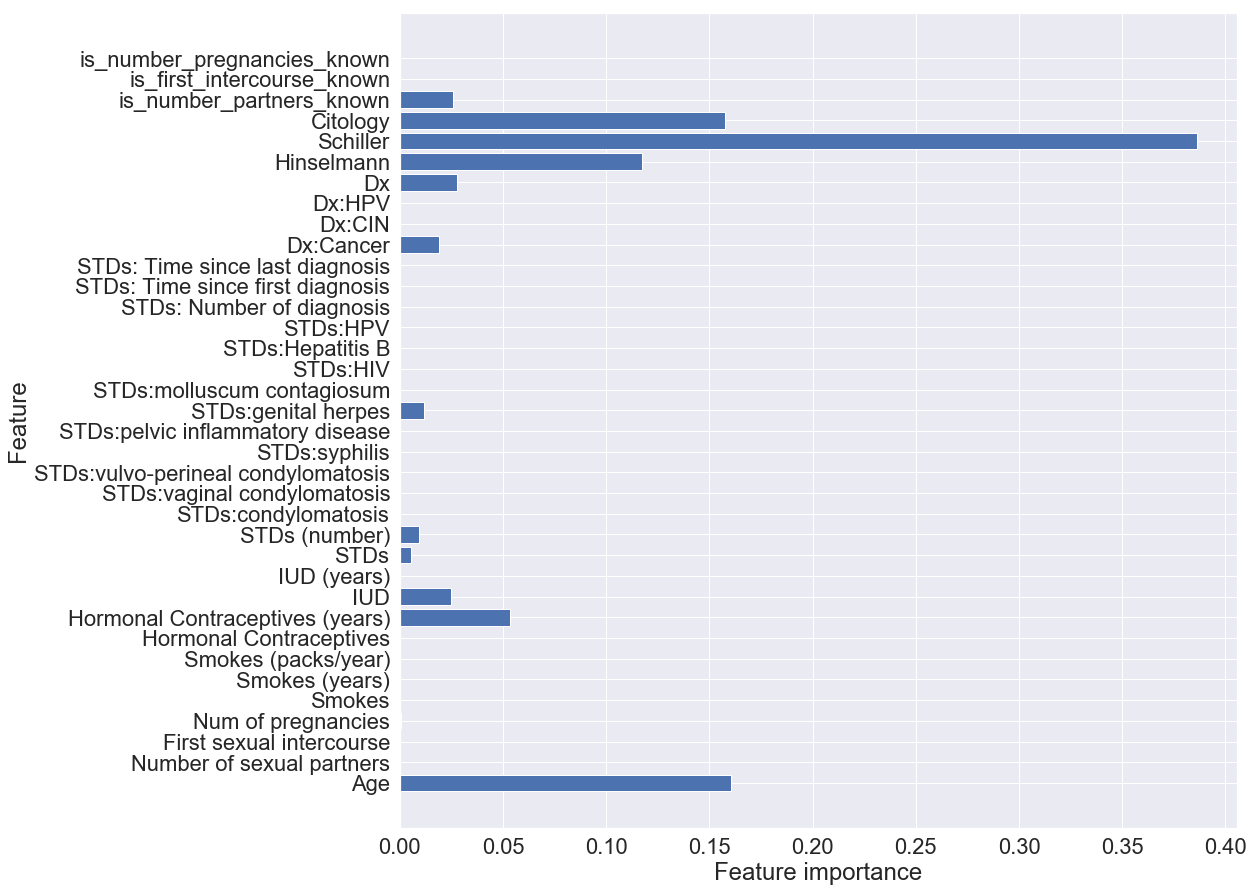

In [78]:
plot_feature_importances(forest)
plt.show()

This model did a much better job identifying the factors that showed correlation to Biopsy in the heatmap.
Taking a look at how the trees varied in terms of feature importances:


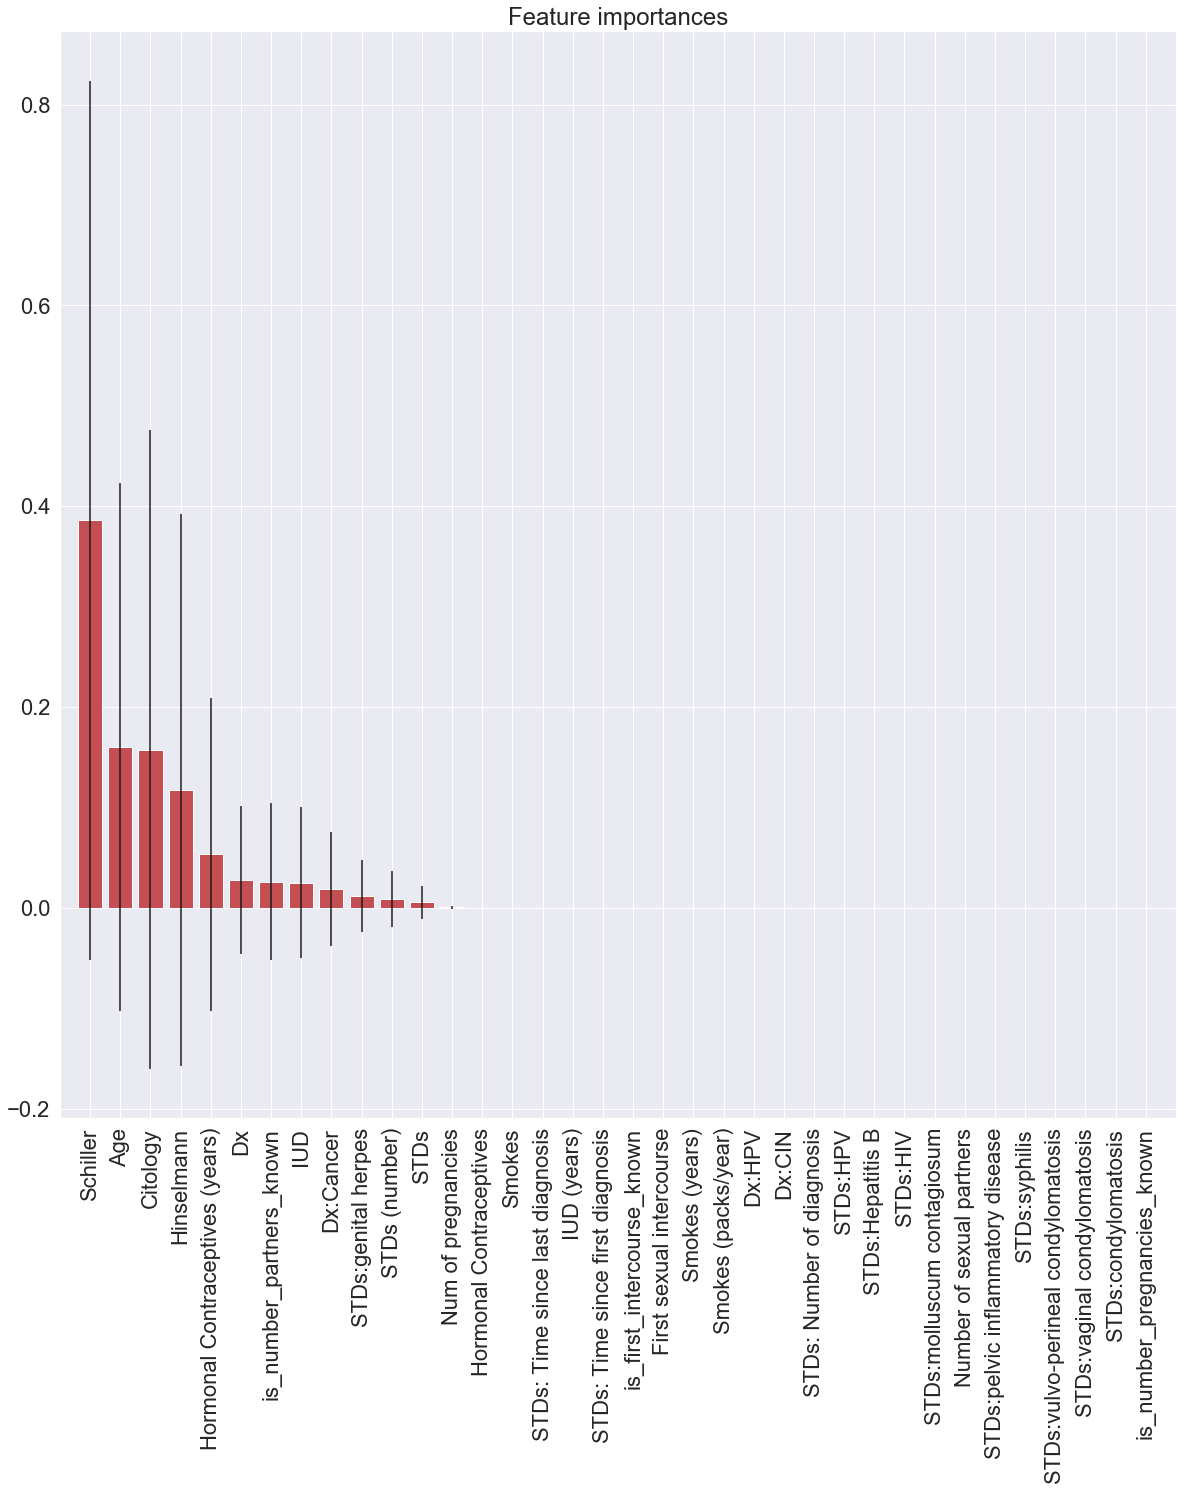

In [79]:
# Plot the feature importances of the forest
plt.figure(figsize=(20,20))
plt.title("Feature importances")

importances = forest.feature_importances_

std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)

label_importance_std = pd.DataFrame(zip(X.columns, importances, std))
label_importance_std.columns = ['Label', 'Importance','STD']

label_importance_std.sort_values('Importance', inplace=True, ascending=False)



plt.bar(range(X_train.shape[1]), label_importance_std['Importance'],
       color="r", yerr=label_importance_std['STD'], align="center")
plt.xticks(range(X_train.shape[1]), label_importance_std['Label'], rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.show()

The solid black line in the middle of the red bars indicates the standard deviation for each factor's importance from all the trees.

Now I will try a random forest model using the resampled data.

In [80]:
# use grid search for the random forest classifier, use recall as the factor to optimize
forest = RandomForestClassifier(random_state=10, n_jobs=-1)

forest_param_grid = {
    'class_weight': [None],
    'criterion': ['gini', 'entropy'],
    'max_depth': [5, 6, 7, 8, 9, 10, 11, 12],
    'n_estimators': [10, 20, 30, 40, 50, 60]}

forest_grid_search = GridSearchCV(forest,
                                  param_grid = forest_param_grid, 
                                  scoring = 'recall',
                                  cv=3,
                                  return_train_score=True)

In [81]:
import time
start = time.time()

forest_grid_search.fit(X_train_res, y_train_res)

print("Testing Accuracy: {:.4}%".format(forest_grid_search.best_score_ * 100))
print("Total Runtime for Grid Search on Random Forest Classifier: {:.4} seconds".format(time.time() - start))
print("")
print("Optimal Parameters: {}".format(forest_grid_search.best_params_))

Testing Accuracy: 99.38%
Total Runtime for Grid Search on Random Forest Classifier: 74.4 seconds

Optimal Parameters: {'class_weight': None, 'criterion': 'gini', 'max_depth': 8, 'n_estimators': 40}


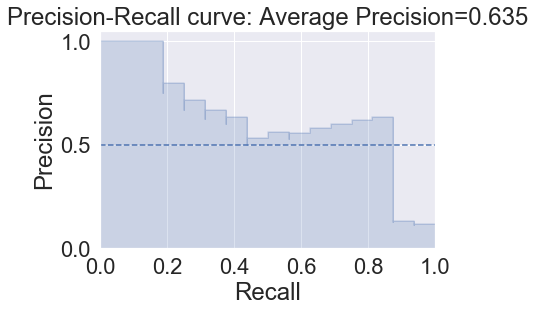

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.95      0.95       156
           1       0.53      0.56      0.55        16

    accuracy                           0.91       172
   macro avg       0.74      0.76      0.75       172
weighted avg       0.92      0.91      0.91       172

f1=0.545 auc=0.623 recall=0.562


In [82]:
#create the model using the best parameters
forest = RandomForestClassifier(criterion='gini', 
                                             max_depth=8, 
                                             n_estimators=40, 
                                             random_state=10, 
                                             n_jobs=-1)

analysis(forest, X_train_res, y_train_res)


Again the recall and F1 scores are lower when using the resampled data.

## SVM

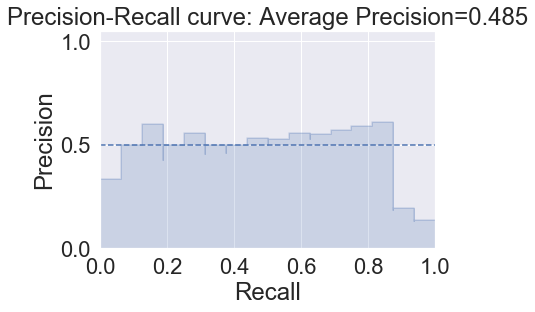

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.94      0.96       156
           1       0.59      0.81      0.68        16

    accuracy                           0.93       172
   macro avg       0.79      0.88      0.82       172
weighted avg       0.94      0.93      0.94       172

f1=0.684 auc=0.454 recall=0.812


In [83]:
#SVM with class_weight='balanced'
clf = svm.SVC(cache_size=1000, gamma='scale', class_weight='balanced', probability=True)

analysis(clf, X_train, y_train)

Both recall and F1 scores improved markedly when using 'balanced' as the class_weight parameter. Now try with the resampled data.

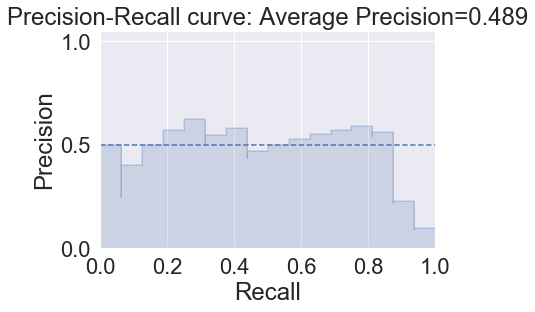

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.94      0.95       156
           1       0.53      0.62      0.57        16

    accuracy                           0.91       172
   macro avg       0.74      0.78      0.76       172
weighted avg       0.92      0.91      0.92       172

f1=0.571 auc=0.453 recall=0.625


In [84]:
#try with resampled data
clf = svm.SVC(cache_size=1000, gamma='scale', probability=True)

analysis(clf, X_train_res, y_train_res)

Again, the model performs worse when using the resampled data.

***

# Interpret

Of the five models explored, the Random Forest was the most successsful when ranked by the recall and F1 measurements, in that order.

A recall score of 0.875 was reached by three models:
* Logistic Regression
* Decision Tree
* Random Forest

As anticipated, KNN performed the poorest, especially regarding recall.

Creating fictitous data samples was quite helpful with the logistic regression and KNN models, while the remaining models performed better with the original data and using their built-in parameters to balance the classes.




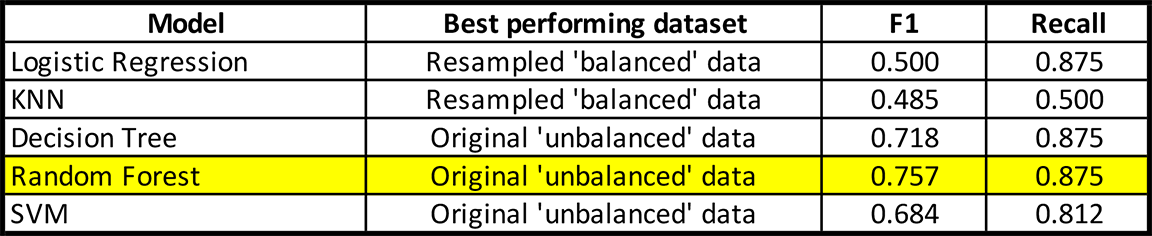